## Reducing Dimensionality

There are two main drivers of dimensionality in this dataset: Keywords and Production Companies

Both bring thousands of dummy variables and create a sparse matrix that must be used for modelling.  I have several other categories that increase dimensionality more than they should, from these I need to severely reduce the number of features that are present in my data.  I'll list the general approach for each here, and enumerate why I'm taking that approach in subsections below. 

**Keywords:** Eliminate any keyword that appears in less than fifty films, reducing to 23 features

**Production Companies:** Bin this by quartiles, reducing to 4 features

**Release Year:** Bin by decade, reducing to 6 features

**Production Country:** Eliminate and create a single column indicating if a film was produced in the US or not

Once I've reduced the dimensionality appropriately I'll test the performance of linear, random forest, gradient boosting, xgboost, and k-nearest neighbors regression models. I will also compare model performance using RMSE and R-squared metrics as well as examining the models residual plots. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

In [2]:
boxoffice = pd.read_csv('../Data/No_Outliers2.csv', index_col=0, header=[0,1])

In [3]:
# Copying the boxoffice dataframe prior to making major changes so that I have access to all the information
# if any mistakes are made. 
box = boxoffice
box.shape

(1983, 9976)

### Keywords

The Keywords category adds 7,134 dimensions to this data set and is incredibly sparse.  Only 1000 keywords actually appear in more than 5 films.  As a starting point I'm going to eliminate all keywords that don't appear in in at least 50 films, which reduces this category by 7,123 dimensions to 11 features. 

I would prefer to bin keywords by quartiles as I'll do with production companies. This presents problems to stakeholders who would like to make predictions from this model for a film's revenue.  If keywords are binned by revenue, you need to consult the existing list of keywords to identify which quartile a keywords belongs to.  This by itself isn't a problem.  However, over half of all keywords appear in only a single film, and many are a garbled collection of symbols that are not interpretable. A single previous data point is not a good predictor of revenue, further compounded by the likelihood that a keyword has not appeared in a single film previously.  

If a keyword has not previously appeared in a film, it's impossible to use prior revenue performance to predict future revenue performance.  As a result, I've chosed to bin keywords by their frequency in the data set. 

In [4]:
sums = boxoffice['Keywords']
sums = sums.sum(axis=1)
# create a new column that indicates the number of keywords that participate in the creation of a film
box['Numerical', 'Num_keywords'] = sums

In [5]:
# Create a list of keywords that appear in more than 50 films
kwrds = boxoffice['Keywords']
count = kwrds.apply(pd.value_counts)
count = count.iloc[1]
pd.DataFrame(count)
new_cols = list(count[count>=50].index)

In [6]:
# drops all keyword columns that don't appear in more than 50 films
old_cols = list(box['Keywords'].columns)
old_cols = set(old_cols)
new_cols = set(new_cols)
drop = old_cols.difference(new_cols)
drop = list(drop)
box.drop(drop, axis=1, level=1, inplace=True)
box.drop('No Keywords', axis=1, level=1, inplace=True)
box.shape

(1983, 2853)

### Production Companies

Next, I need to bin production companies by revenue tier.  This will involve reducing the 2,688 features for Production Companies down to 4 features for production company revenue quartiles. These will indicate if a film has a production company who's fims are generally in the 25th, 50th, 75th, or 100th quartile of film revenue. 

I'm also going to sum up all the rows for production companies and create a new column that indicates the number of companies that contribute to a film since each film can have multiple companies working on it.

In [7]:
sums = boxoffice['Company']
sums = sums.sum(axis=1)
# create a new column that indicates the number of companies that participate in the creation of a film
box['Numerical', 'Num_companies'] = sums

In [8]:
# Creating a dataframe of the production company data joined with revenue data
rev = boxoffice['Numerical', 'revenue']
rev = pd.DataFrame(rev)
rev.columns = rev.columns.droplevel()
prod_co = boxoffice['Company']
prod_co_rev = prod_co.join(rev)

In [9]:
# Creating a series that lists companies by the average revenue they produce
median={}
for x in prod_co_rev:
    median[x] = prod_co_rev['revenue'][prod_co_rev[x] == 1].median()
medians = pd.Series(median)
medians.sort_values(ascending=False)

Marvel Studios                263427551.0
MVL Incredible Productions    263427551.0
Shinework Media               263036301.0
Taihe Entertainment           263036301.0
Atlantic Television           262520724.0
                                 ...     
XM3 Service                           NaN
Zehnte Babelsberg                     NaN
thinkfilm                             NaN
warner bross Turkey                   NaN
revenue                               NaN
Length: 2689, dtype: float64

Interesting that film companies have no revenue. However this would indicate that these companies simply don't have films observed in the data set.  This is not that surprising considering that in the previous notebook I eliminated 5% of the observations.  It is surprising that Warner Bros. is one of those companies with no films present, however it is reasonable that Warner Bros films would be in the top 5% of revenue since it's one of the most well-known companies.

In [10]:
# verifying that the number of production companies with less than 5%
print('Number of film companies with no films: ', medians.isnull().sum())
print('% of film companies with no films: ' + str(medians.isnull().sum() / len(medians)))

Number of film companies with no films:  177
% of film companies with no films: 0.06582372629230197


In [11]:
# creating a list of production company names to drop later since their films have been dropped from the data set
mask = medians.isnull()
droplist = list(medians[mask].index)
# Edit the series to 
reverse = medians[medians.notnull()]
reverse = reverse.sort_values(ascending=False)
reverse.shape

(2512,)

In [12]:
# Cutting the list of companies & revenue into quartiles
reverse = pd.DataFrame(reverse, columns = ['revenue'])
reverse['Quartile'] = pd.qcut(reverse['revenue'], q=4, labels=False)
# Creating a list of company names for each quartile
quartile_1st = list(reverse[reverse['Quartile'] == 0].index)
quartile_2nd = list(reverse[reverse['Quartile'] == 1].index)
quartile_3rd = list(reverse[reverse['Quartile'] == 2].index)
quartile_4th = list(reverse[reverse['Quartile'] == 3].index)

In [13]:
# Nested for loops that create new columns that indicate if a film was contributed to by a production company who's average film
# revenue is in the 1st, 2nd, 3rd, or 4th quartiles
for i in quartile_1st:
    for k in prod_co.index:
        if prod_co.loc[k,i] == 1:
            box.loc[k, ('Company', 'Company_quartile_1st')] = 1
            
for i in quartile_2nd:
    for k in prod_co.index:
        if prod_co.loc[k,i] == 1:
            box.loc[k, ('Company', 'Company_quartile_2nd')] = 1
        
for i in quartile_3rd:
    for k in prod_co.index:
        if prod_co.loc[k,i] == 1:
            box.loc[k, ('Company', 'Company_quartile_3rd')] = 1
        
for i in quartile_4th:
    for k in prod_co.index:
        if prod_co.loc[k,i] == 1:
            box.loc[k, ('Company', 'Company_quartile_4th')] = 1      

In [14]:
co = box['Company']
co = co.apply(pd.value_counts)
co = co.iloc[1]
keep = co[co>50]
keep = pd.DataFrame(keep)
keep = keep.drop(['Company_quartile_1st', 'Company_quartile_2nd', 'Company_quartile_3rd', 'Company_quartile_4th'], axis=0)
keep = set(list(keep.index))
drop = set(list(prod_co.columns))
drop = list(drop.difference(keep))
box = box.drop(drop, axis=1, level=1)

In [15]:
box['Company'] = box['Company'].fillna(0)
box['Company'] = box['Company'].astype(int)
box.shape

(1983, 181)

### Realease Year

Generally speaking in the exploratory data analysis for this problem I noticed that revenue increased year over year.  This trend can also be captures by features representing the decade for which a film is produced in.  This will reduce the dimensions of the data set by 41 features.

In [16]:
years = boxoffice['Release_year']
years.columns

Index(['1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979',
       '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988',
       '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997',
       '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006',
       '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016', '2017', 'No Year'],
      dtype='object')

In [17]:
Decade_70s = ['1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979']
Decade_80s = ['1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989']
Decade_90s = ['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999']
Decade_00s = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009']
Decade_10s = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']
for i in Decade_70s:
    for k in years.index:
        if years.loc[k,i] == 1:
            box.loc[k, ('Release_year', "70s")] = 1
for i in Decade_80s:
    for k in years.index:
        if years.loc[k,i] == 1:
            box.loc[k, ('Release_year', '80s')] = 1
for i in Decade_90s:
    for k in years.index:
        if years.loc[k,i] == 1:
            box.loc[k, ('Release_year', '90s')] = 1
for i in Decade_00s:
    for k in years.index:
        if years.loc[k,i] == 1:
            box.loc[k, ('Release_year', '00s')] = 1
for i in Decade_10s:
    for k in years.index:
        if years.loc[k,i] == 1:
            box.loc[k, ('Release_year', '10s')] = 1

In [18]:
box = box.drop(['1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979',
       '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988',
       '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997',
       '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006',
       '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016', '2017'], axis=1, level=1)
box['Release_year'] = box['Release_year'].fillna(0)
box['Release_year'] = box['Release_year'].astype(int)
box.shape

(1983, 139)

### Country

Production country is the last category in this data set that has a sparse matrix of data to work with.  I'm going to group the country information by global region, and I'll also create a new numerical column that indicates if a film was produced in multiple countries.  

This will reduce the data set that I'm working with by 55 features.

In [19]:
sums = boxoffice['Country']
sums = sums.sum(axis=1)
box['Numerical', 'Num_production_countries'] = sums

In [20]:
country = boxoffice['Country']
europe = ['Austria', 'Belgium', 'Bulgaria', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 
          'Hungary', 'Iceland', 'Ireland', 'Italy', 'Luxembourg', 'Malta', 'Monaco', 'Netherlands', 'Norway', 'Poland', 
          'Portugal', 'Romania', 'Russia', 'Serbia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland']
oceania = ['Australia', 'Indonesia', 'New Zealand', 'Philippines']
asia = ['Cambodia', 'China', 'Hong Kong', 'Japan', 'Singapore', 'South Korea', 'Taiwan', 'Thailand', 'India']
middleast = ['Iran', 'Israel', 'Pakistan', 'Qatar', 'Turkey', 'United Arab Emirates']
latinamerica = ['Argentina', 'Bahamas', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Costa Rica', 'Peru', 'Paraguay',
                'Uruguay', 'Venezuela']
northamerica = ['Canada', 'Mexico']
africa = ['Botswana', 'Mauritania', 'Morocco', 'South Africa']

In [21]:
for i in europe:
    for k in country.index:
        if country.loc[k, i] == 1:
            box.loc[k, ('Country', 'Europe')] = 1
for i in oceania:
    for k in country.index:
        if country.loc[k, i] ==1:
            box.loc[k, ('Country', 'Oceania')] = 1
for i in asia:
    for k in country.index:
        if country.loc[k, i] ==1:
            box.loc[k, ('Country', 'Asia')] = 1
for i in middleast:
    for k in country.index:
        if country.loc[k, i] ==1:
            box.loc[k, ('Country', 'Middle_East')] = 1
for i in latinamerica:
    for k in country.index:
        if country.loc[k, i] ==1:
            box.loc[k, ('Country', 'Latin_America')] = 1
for i in northamerica:
    for k in country.index:
        if country.loc[k, i] ==1:
            box.loc[k, ('Country', 'North_America')] = 1
for i in africa:
    for k in country.index:
        if country.loc[k, i] ==1:
            box.loc[k, ('Country', 'Africa')] = 1

In [22]:
regions = europe + oceania + asia + middleast + latinamerica + northamerica + africa
box = box.drop(regions, level=1, axis=1)
box['Country'] = box['Country'].fillna(0)
box['Country'] = box['Country'].astype(int)
box.shape

(1983, 84)

In [23]:
box.to_csv('../Data/Reduced_dimensions2.csv')

# Testing the performance of regression models on the reduced data set

Now that I've severely reduced the dimensionality of this data I'm going to test a linear, random forest, gradient boosting, Support-Vector, and k-nearest neighbors regression models.

Based on the results from cross-validation I'll then test out of the box models against the test data and plot their residuals as well as calculate the mean absolute percentage error. 

### V 1.0 - due to another project and specialized third party packages I'm currently unable to access scikit-learn 0.24 and thus cannot use mean_absolute_percentage_error within cross-validation

### V 2.0 - I realized in a later notebook that I had been incorrectly scoring my ML models and used those incorrect scores to select a model.  I'm going back through here and using the correct scoring methods to asses model performance

The proper way to calculate MAPE/RMSE/R2/MAE metrics from log transformed target variables is to take the exponential of both the hold-out/test set and the predicted variables and THEN calculate error metrics.  However this isn't possible with scoring for cross-validation purposes.  While the metrics that will be provided by cross-validation are metrics for 'log(dollars)', and thus aren't truly representative of the actual performance of the model, they do allow for a point of comparison between models since the units are all the same that WILL allow me to select the best performing models on the log(dollars) target.

In [24]:
metrics = ['neg_mean_squared_error', 'r2']
# Taking the log of numerical revenue and 
y = np.log(box['Numerical', 'revenue'])
X = box.drop('revenue', level=1, axis=1)
# Scaling the numerical data in X using a standard scaler
scaler=MinMaxScaler()
scaler.fit(X['Numerical'])
X['Numerical'] = scaler.transform(X['Numerical'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# instantiating the regression models
linear = LinearRegression()
random_forest = RandomForestRegressor()
knn = KNeighborsRegressor()
gradient_boost = GradientBoostingRegressor()
svr = SVR()

In [26]:
# Getting linear regression scores
results = cross_validate(linear, X_train, y_train, scoring=metrics)
# takinge the exponential of the RMSE to transform it back into real dollars
RMSE = round(np.sqrt(np.mean(np.abs(results['test_neg_mean_squared_error']))), 5)
R2 = round(np.mean(results['test_r2']), 5)
linear_results = {'RMSE':RMSE, 'R2':R2}
print('Linear RMSE: ', RMSE)
print('Linear R2: ', R2)

Linear RMSE:  57929816354.73548
Linear R2:  -1.6553251119669437e+21


In [27]:
# Getting Random Forest scores
results = cross_validate(random_forest, X_train, y_train, scoring=metrics)
RMSE = round(np.sqrt(np.mean(np.abs(results['test_neg_mean_squared_error']))), 5)
R2 = round(np.mean(results['test_r2']), 5)
random_forest_results = {'RMSE':RMSE, 'R2':R2}
print('Random Forest RMSE: ', RMSE)
print('Random Forest R2: ', R2)

Random Forest RMSE:  0.95836
Random Forest R2:  0.56327


In [28]:
# Getting KNN scores
results = cross_validate(knn, X_train, y_train, scoring=metrics)
RMSE = round(np.sqrt(np.mean(np.abs(results['test_neg_mean_squared_error']))), 5)
R2 = round(np.mean(results['test_r2']), 5)
knn_results = {'RMSE':RMSE, 'R2':R2}
print('K-Nearest Neighbor RMSE: ', RMSE)
print('K-Nearest Neighbor R2: ', R2)

K-Nearest Neighbor RMSE:  1.08905
K-Nearest Neighbor R2:  0.43897


In [29]:
# Getting Gradient Boosted scores
results = cross_validate(gradient_boost, X_train, y_train, scoring=metrics)
RMSE = round(np.sqrt(np.mean(np.abs(results['test_neg_mean_squared_error']))), 5)
R2 = round(np.mean(results['test_r2']), 5)
gradient_boosted_results = {'RMSE':RMSE, 'R2':R2}
print('Gradient Boosted RMSE: ', RMSE)
print('Gradient Boosted R2: ', R2)

Gradient Boosted RMSE:  0.94868
Gradient Boosted R2:  0.57323


In [30]:
# Getting Support Vector Regression results
results = cross_validate(svr, X_train, y_train, scoring=metrics)
RMSE = round(np.sqrt(np.mean(np.abs(results['test_neg_mean_squared_error']))), 5)
R2 = round(np.mean(results['test_r2']), 5)
support_vector_results = {'RMSE':RMSE, 'R2':R2}
print('Support Vector RMSE: ', RMSE)
print('Support Vector R2: ', R2)

Support Vector RMSE:  0.97579
Support Vector R2:  0.554


In [31]:
# Collecting results for comparison
scores = {'Linear': linear_results, 'Random Forest':random_forest_results, 'KNN':knn_results, 
          'Gradient Boosted':gradient_boosted_results, 'SVR':support_vector_results}
scores = pd.DataFrame(scores)
scores = scores.T
scores = scores.drop('Linear', axis=0)
scores

,RMSE,R2
Random Forest,0.95836,0.56327
KNN,1.08905,0.43897
Gradient Boosted,0.94868,0.57323
SVR,0.97579,0.55400


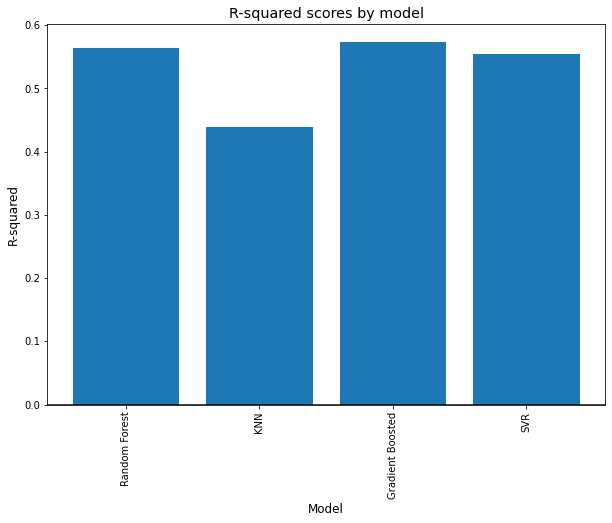

In [32]:
models = list(scores.index)
plt.figure(figsize=(10,7))
plt.bar(models, scores.R2)
plt.xticks(rotation=90)
plt.axhline(0, c='black')
plt.xlabel('Model', size='large')
plt.ylabel('R-squared', size='large')
plt.title('R-squared scores by model', size = 'x-large');

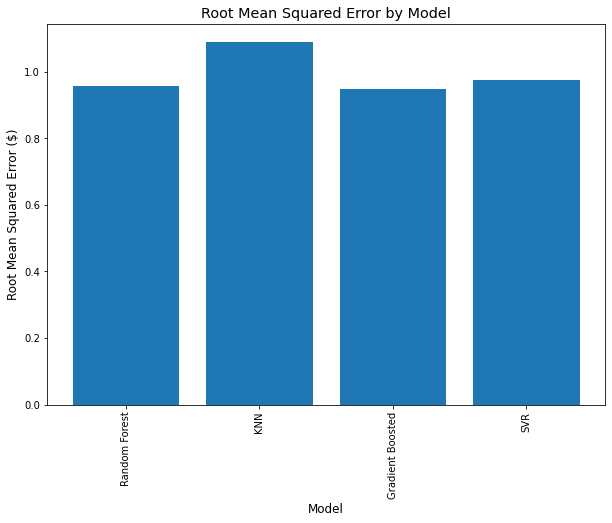

In [33]:
plt.figure(figsize=(10,7))
plt.bar(models, scores.RMSE)
plt.xticks(rotation=90)
plt.xlabel('Model', size='large')
plt.ylabel('Root Mean Squared Error ($)', size='large')
plt.title('Root Mean Squared Error by Model', size='x-large');

### Testing against test data and plotting residuals

Based on cross-validation it seems that decision-tree based regression models as well as KNN regression performs the best.  While the SVR model did recieve better scores, it also raised error warnings that the model is not converging, so I won't be using it going forward.  I'm going to test their performance against my test data as well as take the opportunity to plot their residuals.  


#### V 2.0  As of now I'm unsure of how to best use randomized search for hyperparameter tuning and will move forward with the best performing hyperparameters from previous iterations on this notebook.  I'm still unable to update to scikit learn 0.24 and use their MAPE function so I've written my own below

The purpose of going back over this notebook is to ensure that data has been properly transformed from log(dollars) to regular dollars PRIOR to scoring each model.  This will likely change the approach that I take for randomized search as well after consulting several mentors for strategies around that.

In [34]:
# function to calculate mean absolute percentage error
def MAPE(true_values, predicted_values):
    MAPE = np.sum(np.abs((true_values-predicted_values)/true_values))/len(true_values)*100
    return MAPE

In [35]:
box.shape

(1983, 84)

In [36]:
y = np.log(box['Numerical', 'revenue'])
X = box.drop('revenue', level=1, axis=1)
# Scaling the numerical data in X using a MinMax scaler
scaler=MinMaxScaler()
scaler.fit(X['Numerical'])
X['Numerical'] = scaler.transform(X['Numerical'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Training target variables are still in 'log(dollars)' to reduce the skew in the data. I'm going to transform the test data back into 'regular dollars' using np.exp now. After predictions are made with each model I'll transform the predictions with np.exp immediately so that I don't need to insert np.exp() multiple times into each scoring function.  

By going through this in a systematic way I will be able to ensure the fidelity of my scoring metrics prior to modeling revenue based on tiers.

In [37]:
exp_y_test = np.exp(y_test)
# training data is still in log(dollars)
y_train

828     19.009989
549     18.509426
656     18.256660
83      19.340252
1977    17.709410
          ...    
1315    14.597022
1506    15.499579
984     18.463013
1710    18.578495
1311    18.997166
Name: (Numerical, revenue), Length: 1586, dtype: float64

In [38]:
# new variable to store actual revenue values for test data that will be used to compare to predicted values
exp_y_test

672      52000000.0
2307    256697520.0
1446     12272308.0
1271     65409046.0
1052    112483764.0
           ...     
1474    146292009.0
423     178127760.0
1159     63543328.0
1427     75769783.0
678      39753957.0
Name: (Numerical, revenue), Length: 397, dtype: float64

#### Testing a Random Forest model, finding optimal parameters, and plotting residuals for the optimal model

In [39]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
preds = rf.predict(X_test)
preds = np.exp(preds)

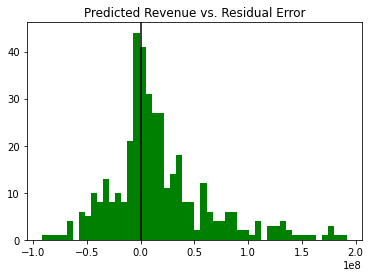

In [40]:
residuals = exp_y_test-preds
plt.hist(residuals,color='g', bins=50)
plt.axvline(x=0, color='k')
plt.title('Predicted Revenue vs. Residual Error');

In [41]:
params = {'n_estimators': np.arange(10,1000), 'min_samples_leaf': np.arange(1,10), 'min_samples_split': np.arange(2,10), 
          'max_depth':np.arange(10,90)}
#rand = RandomizedSearchCV(RandomForestRegressor(), param_distributions=params, n_iter=100)
#rand.fit(X_train, y_train)
#rf_best_score = rand.best_score_
#rf_best_params = rand.best_params_
#print(rf_best_score)
#print(rf_best_params)

In [42]:
best_rf = RandomForestRegressor(n_estimators= 447, min_samples_split= 6, min_samples_leaf= 4, max_depth= 72)
best_rf.fit(X_train, y_train)
rf_preds = best_rf.predict(X_test)
rf_preds = np.exp(rf_preds)
rf_r2 = r2_score(exp_y_test, rf_preds)
rf_rmse = mean_squared_error(exp_y_test, rf_preds, squared=False)
rf_mape = MAPE(exp_y_test, rf_preds)
rf_residuals = exp_y_test-rf_preds
RandomForest = {'R2':rf_r2, 'RMSE':rf_rmse, 'MAPE':rf_mape}
RandomForest

{'R2': 0.4420406648548554,
 'RMSE': 49045396.61825671,
 'MAPE': 327.03371546087214}

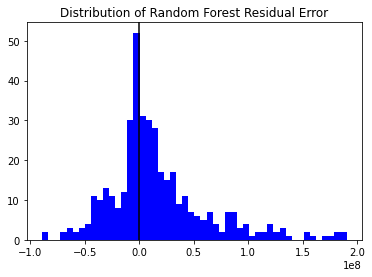

In [44]:
plt.hist(rf_residuals, color='b', bins=50)
plt.axvline(x=0, color='k')
plt.title('Distribution of Random Forest Residual Error');

### Testing a Gradient Boosted model, finding optimal parameters and plotting residuals

In [45]:
grade = GradientBoostingRegressor()
grade.fit(X_train, y_train)
preds = grade.predict(X_test)
preds = np.exp(preds)

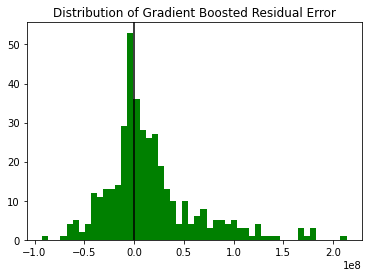

In [46]:
residuals = exp_y_test-preds
plt.hist(residuals,color='g', bins=50)
plt.axvline(x=0, color='k')
plt.title('Distribution of Gradient Boosted Residual Error');

In [47]:
params = {'n_estimators':np.arange(100,10000), 'max_depth':np.arange(3,90), 'min_samples_split': np.arange(2,10)}
#gradient = RandomizedSearchCV(grade, param_distributions=params, n_iter=100)
#gradient.fit(X_train, y_train)
#grade_best_score = gradient.best_score_
#grade_best_params = gradient.best_params_
#print('GB best score: ', grade_best_score)
#print('GB best parameters: ', grade_best_params)

In [48]:
best_gradient=GradientBoostingRegressor(n_estimators= 3086, min_samples_split= 5, max_depth= 6)
best_gradient.fit(X_train, y_train)
grade_preds = best_gradient.predict(X_test)
grade_preds = np.exp(grade_preds)
grade_r2 = r2_score(exp_y_test, grade_preds)
grade_rmse = mean_squared_error(exp_y_test, grade_preds, squared=False)
grade_mape = MAPE(exp_y_test, grade_preds)
GradientBoosted = {'R2':grade_r2, 'RMSE':grade_rmse, 'MAPE':grade_mape}
gb_residuals = exp_y_test-grade_preds
GradientBoosted

{'R2': 0.3757777988847375,
 'RMSE': 51876012.02330454,
 'MAPE': 293.7780962191211}

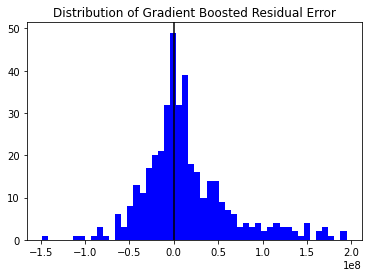

In [50]:
plt.hist(gb_residuals, color='b', bins=50)
plt.axvline(x=0, color='k')
plt.title('Distribution of Gradient Boosted Residual Error');

### Testing a K-Nearest Neighbors model, finding optimal parameters, and plotting residuals

In [51]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
preds = knn.predict(X_test)
preds = np.exp(preds)

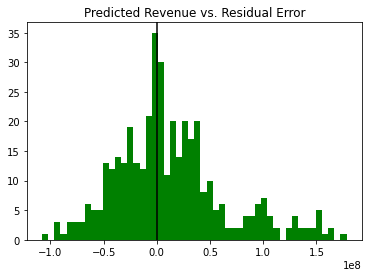

In [52]:
residuals = exp_y_test-preds
plt.hist(residuals, color='g', bins=50)
plt.axvline(x=0, color='k')
plt.title('Predicted Revenue vs. Residual Error');

In [53]:
params = {'n_neighbors':np.arange(2,89)}
#KNN = RandomizedSearchCV(knn, param_distributions=params, n_iter=87)
#KNN.fit(X_train, y_train)
#knn_best_score = KNN.best_score_
#knn_best_params = KNN.best_params_
#print('GB best score: ', knn_best_score)
#print('GB best parameters: ', knn_best_params)

In [54]:
best_knn = KNeighborsRegressor(n_neighbors= 16)
best_knn.fit(X_train, y_train)
knn_preds = best_knn.predict(X_test)
knn_preds = np.exp(knn_preds)
knn_r2 = r2_score(exp_y_test, knn_preds)
knn_rmse = mean_squared_error(exp_y_test, knn_preds, squared=False)
knn_mape = MAPE(exp_y_test, knn_preds)
KNN = {'R2':knn_r2, 'RMSE':knn_rmse, 'MAPE':knn_mape}
knn_residuals = exp_y_test-knn_preds
KNN

{'R2': 0.3624319578592571, 'RMSE': 52427632.54823546, 'MAPE': 570.26490638734}

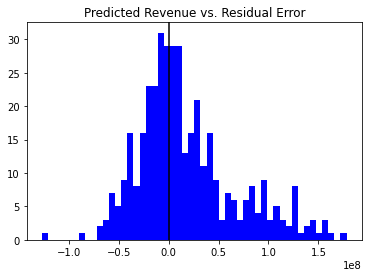

In [56]:
plt.hist(knn_residuals,color='b', bins=50)
plt.axvline(x=0, color='k')
plt.title('Predicted Revenue vs. Residual Error');

In [57]:
params = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[1,5,10], 'degree':[3,8], 
          'coef0':[0.01,10,0.5], 'gamma':('auto','scale')}
#SVR_ = RandomizedSearchCV(svr, param_distributions=params, n_iter=87)
#SVR_.fit(X_train, y_train)
#svr_best_score = SVR_.best_score_
#svr_best_params = SVR_.best_params_
#print('SVR best score: ', svr_best_score)
#print('SVR best parameters: ', svr_best_params)

In [58]:
best_svr = SVR(kernel= 'rbf', gamma= 'auto', degree=8, coef0=0.5, C=10)
best_svr.fit(X_train, y_train)
svr_preds = best_svr.predict(X_test)
svr_preds = np.exp(svr_preds)
svr_r2 = r2_score(exp_y_test, svr_preds)
svr_rmse = mean_squared_error(exp_y_test, svr_preds, squared=False)
svr_mape = MAPE(exp_y_test, svr_preds)
SVR = {'R2':svr_r2, 'RMSE':svr_rmse, 'MAPE':svr_mape}
svr_residuals = exp_y_test-svr_preds
SVR

{'R2': 0.4901487255147593,
 'RMSE': 46883360.29055019,
 'MAPE': 443.0215891985608}

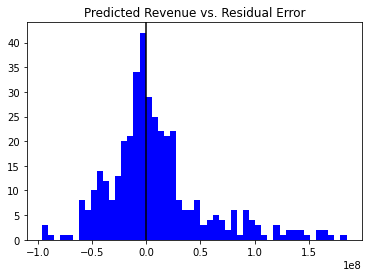

In [60]:
plt.hist(svr_residuals,color='b', bins=50)
plt.axvline(x=0, color='k')
plt.title('Predicted Revenue vs. Residual Error');

## Comparative Analysis of Optimized Model scores

In [61]:
dict_ = {'Random Forest':RandomForest, 'Gradient Boosting':GradientBoosted, 'K-nearest Neighbors':KNN, 
         'Support Vector Regressor': SVR}
opti_scores = pd.DataFrame(dict_)
opti_scores = opti_scores.T
opti_scores

,R2,RMSE,MAPE
Random Forest,0.442041,4.904540e+07,327.033715
Gradient Boosting,0.375778,5.187601e+07,293.778096
K-nearest Neighbors,0.362432,5.242763e+07,570.264906
Support Vector Regressor,0.490149,4.688336e+07,443.021589


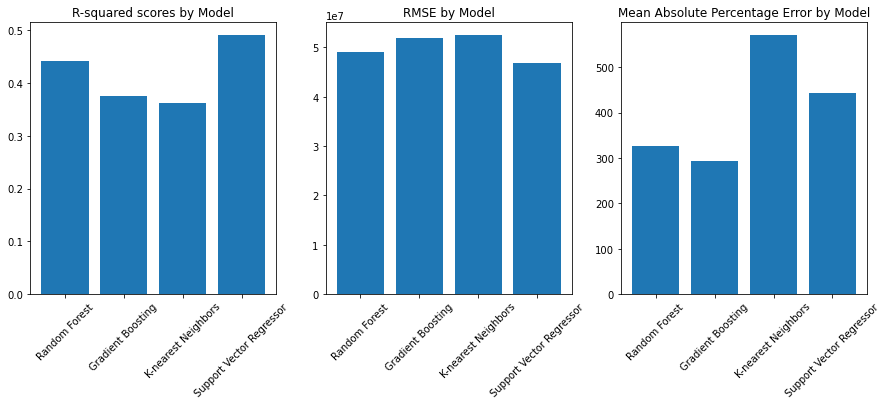

In [62]:
models = list(opti_scores.index)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 5))
fig.figure
ax1.bar(models, opti_scores.R2)
ax1.set_title('R-squared scores by Model')
ax1.set_xticklabels(models, rotation=45)
ax2.bar(models, opti_scores.RMSE)
ax2.set_title('RMSE by Model')
ax2.set_xticklabels(models, rotation=45)
ax3.bar(models, opti_scores.MAPE)
ax3.set_title('Mean Absolute Percentage Error by Model')
ax3.set_xticklabels(models, rotation=45);

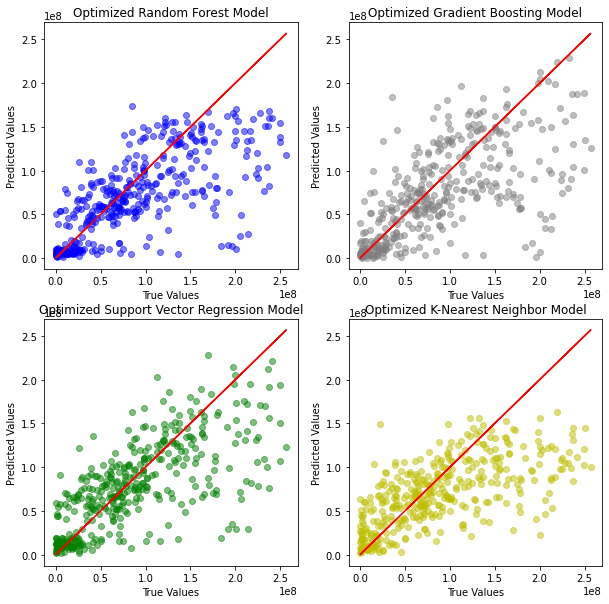

In [80]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10))
ax1.scatter(exp_y_test, rf_preds, alpha=0.5, color='b')
ax1.set_title('Optimized Random Forest Model')
ax1.set_ylabel('Predicted Values')
ax1.set_xlabel('True Values')
ax1.plot(exp_y_test, exp_y_test, color='r')
ax2.scatter(exp_y_test, grade_preds, alpha=0.5, color='grey')
ax2.set_title('Optimized Gradient Boosting Model')
ax2.set_ylabel('Predicted Values')
ax2.set_xlabel('True Values')
ax2.plot(exp_y_test, exp_y_test, color='r')
ax3.scatter(exp_y_test, svr_preds, alpha=0.5, color='g')
ax3.set_title('Optimized Support Vector Regression Model')
ax3.set_ylabel('Predicted Values')
ax3.set_xlabel('True Values')
ax3.plot(exp_y_test, exp_y_test, color='r')
ax4.scatter(exp_y_test, knn_preds, alpha=0.5, color='y')
ax4.set_title('Optimized K-Nearest Neighbor Model')
ax4.set_ylabel('Predicted Values')
ax4.set_xlabel('True Values')
ax4.plot(exp_y_test, exp_y_test, color='r');
fig

## Residual Analysis using the 'best' model

Based on the above comparison the Gradiend Boosting model provided the best performance with regards to Mean Absolute Percentage Error, for which I'm optimizing these models. 

However if I need a point of comparison with the Gradient Boosing model I'll also check the Support-vector Regression model since that has the lowest RMSE and best R-squared value. 

In order to identify what may be going wrong with my models I'm going to create a new dataframe that contains both the true and predicted values for revenue, as well as the residuals.  I'll be able to use this to check and see if there's a pattern among films with exceptionally high residuals.

In [64]:
# Creating columns with predicted, residual, and percent error values
gb = X_test
gb['Numerical', 'revenue'] = exp_y_test
gb['Numerical', 'predicted'] = grade_preds
gb['Numerical', 'residuals'] = gb_residuals
gb['Numerical', 'Per_Err'] = (np.abs(gb['Numerical', 'residuals'])/gb['Numerical', 'revenue'])*100
gb.shape

(397, 87)

In [65]:
gb = gb.sort_values(by=('Numerical', 'Per_Err'), ascending=False)
gb['Numerical'].head(20)

,budget,runtime,Overview_length,Tag_length,Num_keywords,Num_companies,Num_production_countries,revenue,predicted,residuals,Per_Err
2228,0.141792,0.465686,0.276,0.342723,0.093023,0.043478,0.111111,65000.0,4.009170e+07,-4.002670e+07,61579.544101
548,0.015192,0.220588,0.099,0.159624,0.000000,0.130435,0.000000,155640.0,1.703358e+07,-1.687794e+07,10844.218100
271,0.177241,0.250000,0.148,0.000000,0.093023,0.304348,0.111111,76933.0,4.233353e+06,-4.156420e+06,5402.648555
202,0.177241,0.485294,0.179,0.164319,0.279070,0.000000,0.000000,79298.0,3.869591e+06,-3.790293e+06,4779.809029
642,0.025320,0.377451,0.270,0.000000,0.162791,0.130435,0.111111,518842.0,1.993863e+07,-1.941979e+07,3742.909478
1720,0.030384,0.490196,0.151,0.248826,0.000000,0.043478,0.000000,194827.0,5.980661e+06,-5.785834e+06,2969.729293
1351,0.070896,0.333333,0.255,0.169014,0.488372,0.000000,0.000000,4443890.0,6.547643e+07,-6.103254e+07,1373.403467
355,0.177241,0.245098,0.120,0.220657,0.255814,0.043478,0.000000,208027.0,2.508740e+06,-2.300713e+06,1105.968375
1313,0.126600,0.264706,0.433,0.079812,0.116279,0.000000,0.000000,2800000.0,2.831980e+07,-2.551980e+07,911.421323
1635,0.015192,0.411765,0.068,0.220657,0.023256,0.000000,0.000000,670957.0,6.276065e+06,-5.605108e+06,835.389997


It seems that most of my error is coming from the model significantly over-predicting revenue of films with the test data. It's worth examining how many of these films have an error above our target of 20% and how many are below. 

In [66]:
gb['Numerical', 'Per_Err'][gb['Numerical', 'Per_Err']>20].count()

303

Okay, not great.  Of the 397 films in our test set only 97 fall within our target percentage for error.  Let's take a look at more detailed information on the numerical data. 

In [67]:
#Statistical summary of the residuals, percent error, and predicted vs true values
GB = gb
GB['Numerical', 'residuals'] = GB['Numerical', 'residuals'].apply(np.abs)
GB['Numerical'].iloc[:, ::-1].describe()

,Per_Err,residuals,predicted,revenue,Num_production_countries,Num_companies,Num_keywords,Tag_length,Overview_length,runtime,budget
count,397.000000,3.970000e+02,3.970000e+02,3.970000e+02,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000
mean,293.778096,3.489219e+07,7.273485e+07,8.665712e+07,0.052057,0.105355,0.174506,0.178510,0.303829,0.331605,0.180090
std,3161.874890,3.843666e+07,5.416635e+07,6.574226e+07,0.101868,0.112067,0.136022,0.126722,0.153541,0.102011,0.151071
min,0.016435,9.387877e+03,3.624849e+05,6.500000e+04,0.000000,0.000000,0.000000,0.000000,0.058000,0.132353,0.000076
25%,20.610449,8.627163e+06,2.406703e+07,2.909047e+07,0.000000,0.043478,0.069767,0.107981,0.179000,0.264706,0.070896
50%,40.666519,2.113802e+07,6.642198e+07,7.539505e+07,0.000000,0.086957,0.139535,0.154930,0.284000,0.313725,0.159517
75%,67.733476,4.581642e+07,1.068930e+08,1.304314e+08,0.111111,0.130435,0.255814,0.234742,0.395000,0.377451,0.253201
max,61579.544101,1.945080e+08,2.286937e+08,2.566975e+08,0.888889,0.913043,0.674419,1.000000,0.853000,1.000000,0.987483


It seems that about 25% of the predicted values are falling within the target error of 20%.  The next two quartiles increase at a similar rate to 66% at the 3rd quartile.  Beyond that error sharply increases for the remaining 25% of the test set.   I want to plot a heatmap for the films with the worst revenue and see how these features are related and plot the residuals for this model.

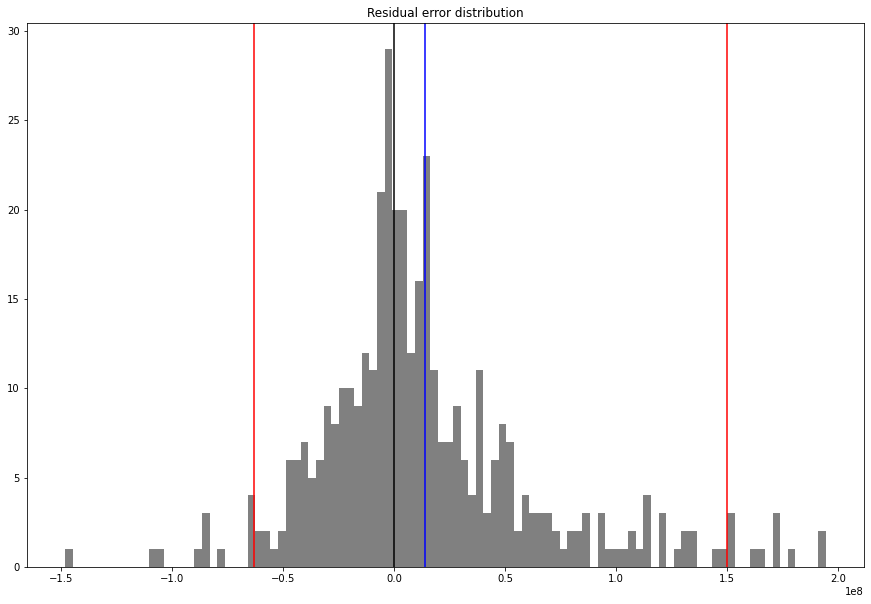

In [82]:
plt.figure(figsize=(15,10))
plt.hist(gb_residuals,color='grey', bins=100)
plt.axvline(x=0, color='k')
# Blue line is the mean of residuals, red lines mark 95% confidence intervals
plt.axvline(x=gb_residuals.mean(), color='b')
plt.axvline(x=150101515, color='r')
plt.axvline(x=-63353025, color='r')
plt.title('Residual error distribution');

In [77]:
Upper = gb_residuals.quantile(0.975)
Lower = gb_residuals.quantile(0.025)
print('Each prediction could vary by as much as $', str(round(Upper, 2)), ' above the predicted value, and $', 
      str(round(np.abs(Lower), 2)), 'below the predicted value.')

Each prediction could vary by as much as $ 150101515.39  above the predicted value, and $ 63353025.38 below the predicted value.


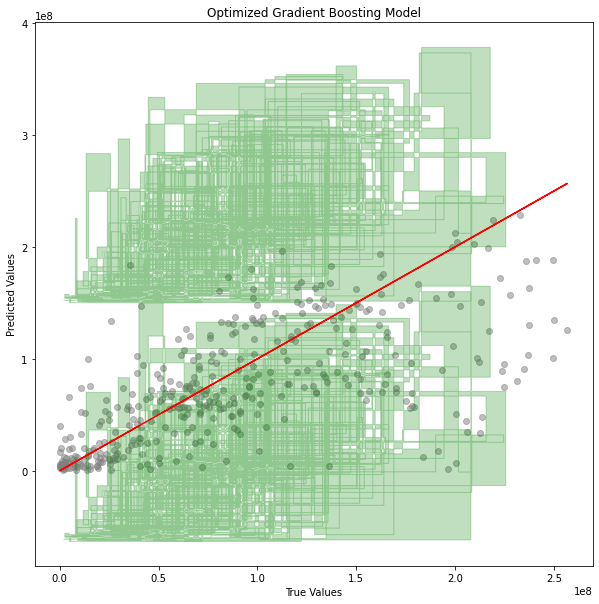

In [89]:
# Plotting predicted vs true values with line of 0 Percent error in red, and error window in green
plt.figure(figsize=(10,10))
plt.scatter(exp_y_test, grade_preds, alpha=0.5, color='grey')
plt.title('Optimized Gradient Boosting Model')
plt.ylabel('Predicted Values')
plt.xlabel('True Values')
plt.plot(exp_y_test, exp_y_test, color='r')
plt.fill_between(exp_y_test, grade_preds+Lower, grade_preds+Upper, alpha=0.25, color='g', step='mid')

### Residual Analysis Conclusion

While The error I have is NOT great, or anywhere near the target.  It IS useable.  With this gradient boosting model I can predict the revenue of a film with 95% confidence that that revenue will be over-predicted by 63,353,025.38 USD, or under-predicted by 150,101,515.39 USD.  While this is not precise in the slightest, this is much better for a business to base decisions around since I would almost always prefer to over-predict rather than under-predict.  

Additionally by reducing the dimensionality of this data set it is much easier to fill in the required information to predict revenue using the information a stakeholder who is working on a film will have at hand.  Additionally, it is possible to make adjustments - want to see what happens if you do increase the budget by 10 million to pay for on-location filming in Costa Rica? Simple adjustment to make. 